In [1]:
%matplotlib inline

In [2]:
from __future__ import division

In [174]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import random as py_random
import patsy
import seaborn as sns
import sklearn.linear_model as linear
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn import tree
import pydotplus
from IPython.display import Image

def examine_data_frame(df):
    for name in df.columns:
        print "----------"
        print df[ name].dtype
        if df[ name].dtype is np.dtype( 'O'):
            print df[ name].value_counts()
            print "Name: ", name
        else:
            print df[ name].describe()
            
def plot_category_counts(df, key):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 2, 1)
    num_of_categories = len(df[key].unique())
    axes.bar(xrange(num_of_categories), df[key].value_counts().values)
    axes.set_title(key)
    axes.set_xticks(xrange(num_of_categories))
    axes.set_xticklabels(df[key].unique(), rotation=45)

def graph_boxplot(data, title):
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(1, 1, 1)
    patch = axes.boxplot(data, labels=["Samples"], patch_artist=True)
    restyle_boxplot(patch)
    x = np.random.normal(1, 0.01, size=len(data))
    axes.set_title(title)
    axes.plot(x, data, 'o', alpha=0.4)
    plt.show()            
            
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)
        
        sns.set(style="darkgrid")
        
def graph_histogram(data, title, bins=None):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 2, 1)
    if bins != None:
        axes.hist(data, bins=bins)
    else:
        axes.hist(data)
    axes.set_title(title)
    axes.set_ylabel( "Count")
    axes.set_xlabel( "Samples")
    axes = figure.add_subplot(1, 2, 2)
    if bins != None:
        axes.hist(data, bins=bins, normed=True)
    else:
        axes.hist(data, normed=True)
    axes.set_ylabel( "Density")
    axes.set_xlabel( "Samples")
    plt.show()
    
def graph_normal_ref(data):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)
    values, base = np.histogram(data, bins=11, density=True)
    cumulative = np.cumsum(values)
    axes.plot( base[:-1], cumulative, color="steelblue")
    axes.set_xlim((np.min(data), np.max(data)))
    weight_mean = np.mean(data)
    weight_std = np.std(data)
    sampled_data = [weight_mean + r * weight_std for r in np.random.standard_normal(10000)]
    values2, base = np.histogram( sampled_data, bins=base, density=True)
    cumulative2 = np.cumsum( values2)
    axes.plot( base[:-1], cumulative2, color="firebrick")
    axes.set_xlim((np.min(data), np.max(data)))
    axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")
    plt.show()
    
def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

def bootstrap_logm( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = map( lambda x: x.strip(), formula.split("~")[1].split( "+"))
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in xrange( samples):
        sampling_indices = [ i for i in [py_random.randint(0, n - 1) for _ in xrange( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = logm( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)

    bootstrap_results[ "resampled_coefficients"] = coeffs
    
    result = logm( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    return bootstrap_results

def describe_bootstrap_fit(result):
    print "regression: ", result[ "formula"]
    print "n: ", result[ "n"]
    print "----------"
    
    bounds = result[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    for variable, coefficient, bound in zip( result[ "variables"], result["coefficients"], bounds):
        print variable + ": ", coefficient, bound 
     
    print "Accuracy: %f%%" % (sum(abs(result['residuals'])) / len(result['residuals']) * 100)
    
def logm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but no LinearRegression

    model = linear.LogisticRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    return result

# Problem Set 5

## Directions

1. Show all work/steps/calculations. Generating Markdown cells for each answer or explanation as needed as well as Code cells for code. 
2. Submission. Follow the general guidelines for submission. They must be in a director/folder that is **your JHED ID** using zip compression and contain everything I need to run your notebook. At minimum,
    1. the .ipynb version of the notebook.
    2. the .html version of the notebook `$ jupyter nbconvert <name of notebook>.ipynb`.
    3. the data file(s) **ARE NOT NEEDED THIS TIME**.
    
    **If we cannot run your code, the entire assignment is wrong, a "0". This is reproducible research.**

2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Labs.
3. All decisions and actions require an explanation. Why did you do it? What did you hope to find out? What did you find out? **Explain and interpret your results. Explain your decisions.** Do not just execute code you copied from the notebooks or previous labs.

## Overview

In this lab you are going to be working with a single data set. [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) You'll be using the `bank-additional-full.csv ` data set.

This data set is interesting for a number of reasons but the chief one is that it comes out of an article called "A Data-Driven Approach to Predict the Success of Bank Telemarketing". This *is* Data Science. It will also give you some practice with a larger data set (40k+ observations).

Make sure you read the Data Dictionary/main page. Pay special attention to the variable `duration` as the note indicates, this variable should not be included in any predictive model. Think about why not so that you can make a similar decisions in the future.

## Steps

1. Download the data set and data dictionary (such that it is). This doesn't have to be in the notebook or even an external file. Some things don't need to be automated.
2. Load the data, doing whatever ETL you need to do.
3. Conduct EDA on the raw data. Remember the comments from Problem Set 2. Do not apply techniques blindly. It's **Exploratory** Data **Analysis** tell me what you are exploring and what you are analyzing. What conclusions did you reach?
4. This is a binary classification task. Pick an appropriate evaluation metric and explain to me the pros and cons.
5. I've made the decision for you to see to use a **Decision Tree**. Build a model using three rounds of 10 fold cross validation or 30 repetitions of bootstrap sampling with 90/10 splits to gauge the generalization error of your model using the evaluation metric you picked.
6. Using all the data, learn the Decision Tree and plot/visualize it. Does it make sense?

Remember the comments to Problem Set 3. Explain everything, make it pretty. Your boss is reading this.

## Extra Credit

In lieu of do overs for the Problem Sets, I am adding the additional extra credit.

1. Repeat your model building exercise with logistic regression. This will require various transformations either because many of the categorical variables are not binary or some of the numerical variables may not work "out of the box".
2. Repeat the cross-validation using the same approach you picked earlier. Was the Decision Tree or Logistic Regression more accurate? Use Statistical Inference techniques from Module 3.
3. Build a logistic regression model using all of the data and the bootstrap LM. Interpret the coefficients.
4. Which model is easier to interpret, Decision Tree or Logistic Regression? Why?
5. Imagine you had to build a system that evaluated 10,000 of these a minute. Which system would you rather deploy into production? Why? Consider support, stakeholder buy-in, engineering infrastructure, etc.

Let's start by reading in the data:

In [82]:
# Read in data
df = pd.read_csv('bank-additional-full.csv', header=0, sep=';')
# Don't forget to delete the 'duration' column
df = df.drop('duration', 1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Next, let's print some general attribute information:

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.3+ MB


In [84]:
examine_data_frame(df)

----------
int64
count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64
----------
object
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
Name:  job
----------
object
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
Name:  marital
----------
object
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
Name:  education
----------
object
no         3

Listing the values like I did above allows me to scope out any values I wasn't expecting or that are missing. In this case, it appears there aren't missing values and all the values make sense.

A look at the numeric attributes shows that the average customer was contacted 2.5 times during the current marketing campaign and never contacted before the current campaign. Based on the ‘employment variation rate’, it looks like employment status had changed recently for most of the participates.

Next, let's look at the frequency at which each value of each categorical value appears in the dataset to identify any imbalances that may exist:

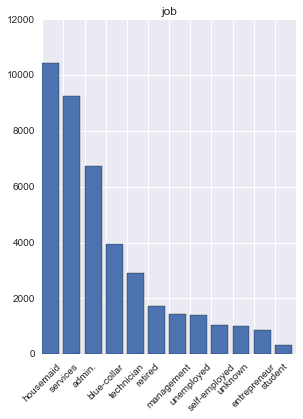

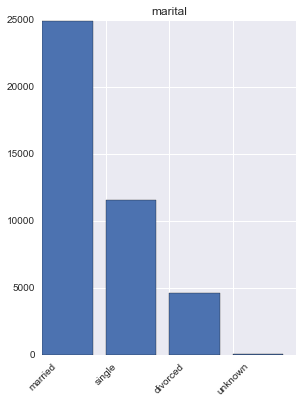

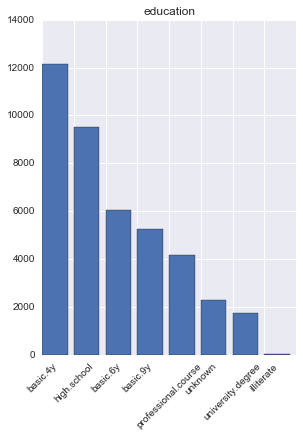

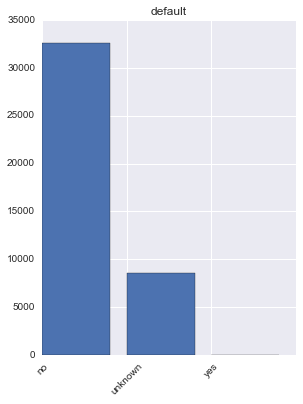

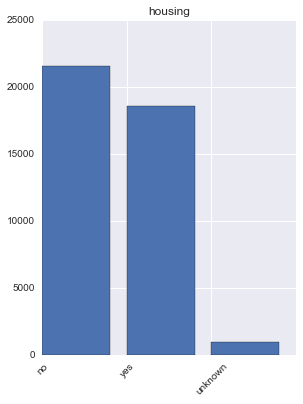

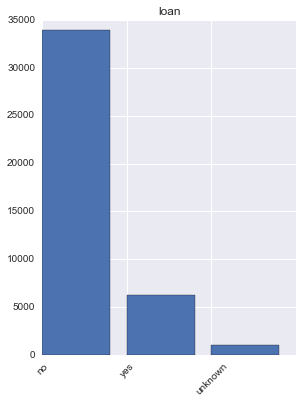

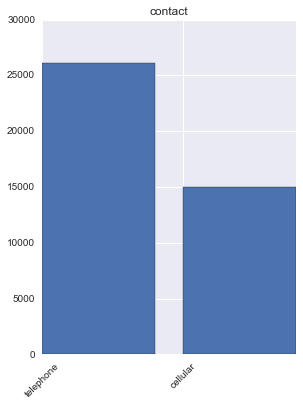

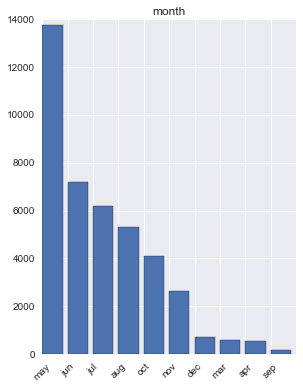

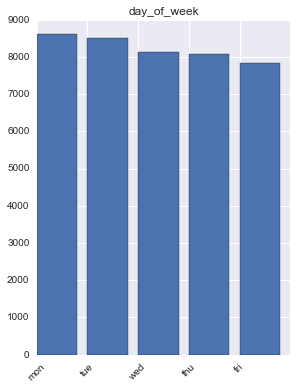

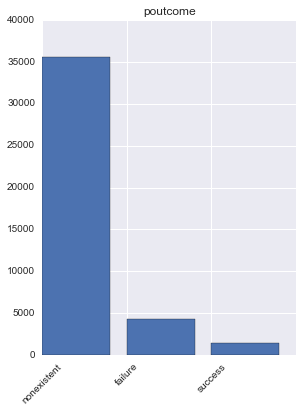

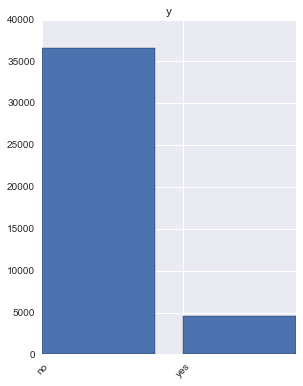

In [85]:
for key in df.keys():
    if df[key].dtype == 'object':
        plot_category_counts(df, key)

Printing the data frame shows us the average age of people used in this data is about 40 years old, with most falling between 30 and 50 years old. It also shows up the jobs these people reported aren’t balanced in the dataset. Most people reporting have a job of ‘admin’, ‘blue-collar’, or ‘technician’. In addition, more than half of the participates were married and and didn’t graduate high school. Most had never had a personal loan or credit in default or had been contacted by the marketing campaign. Home ownership was balanced between ‘yes’ and ‘no’.

We can take a closer look at the numeric attributes by plotting their boxplots and comparing them to the normal distribution:

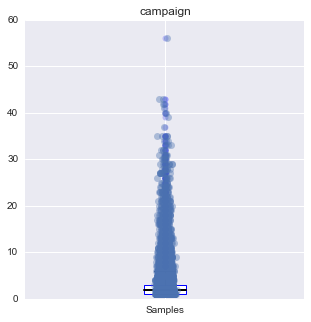

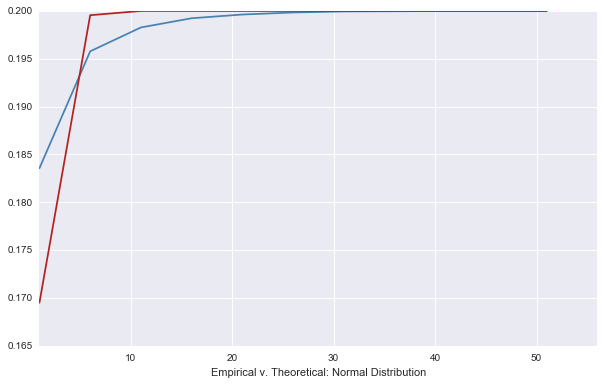

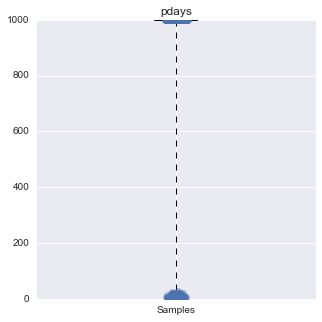

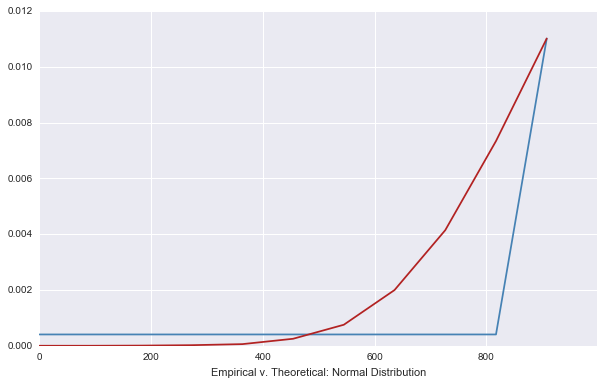

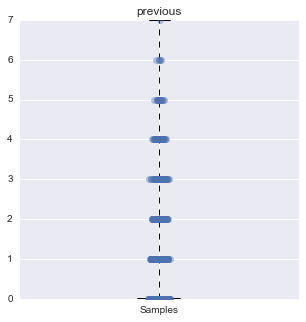

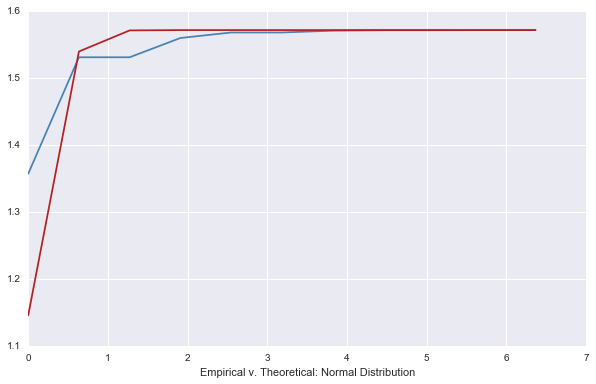

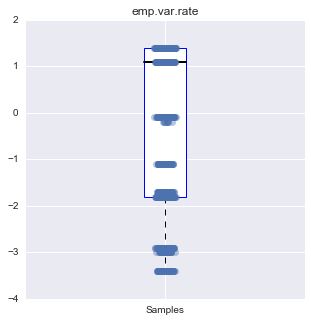

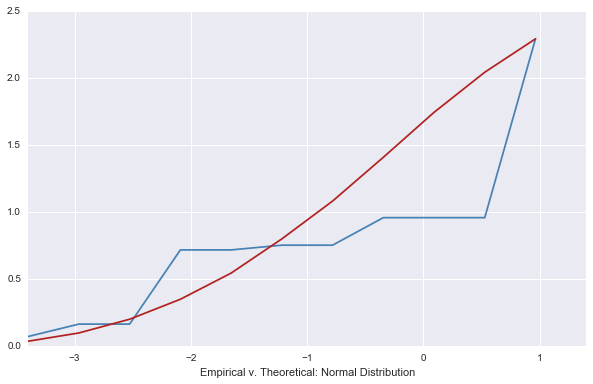

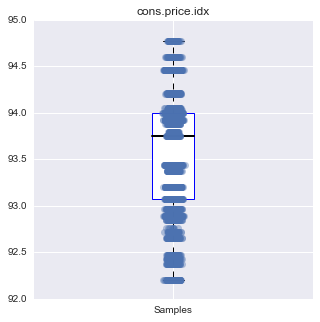

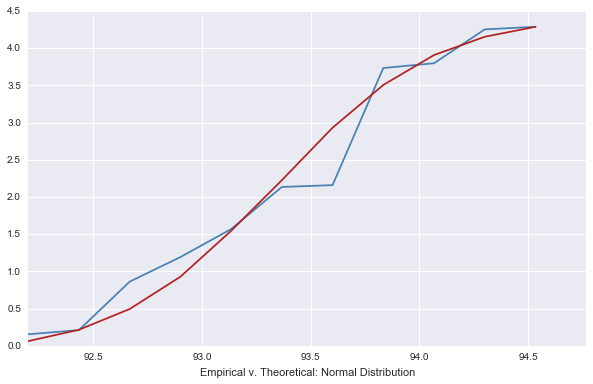

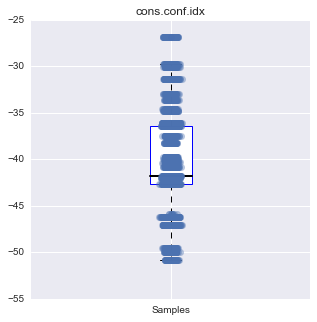

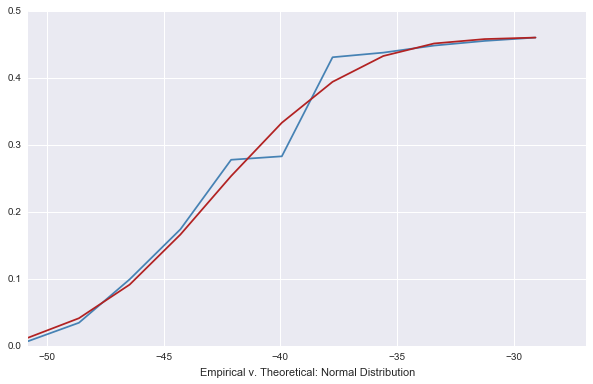

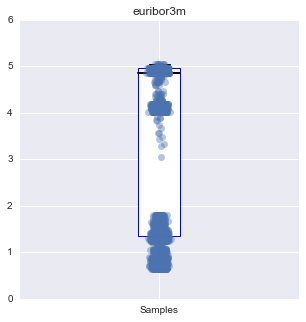

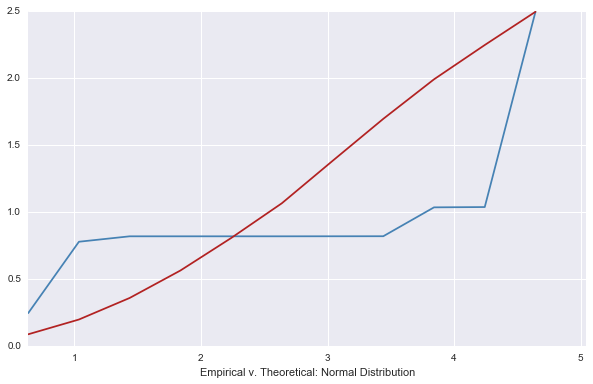

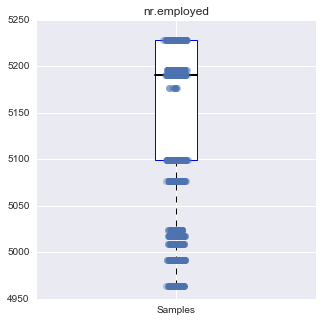

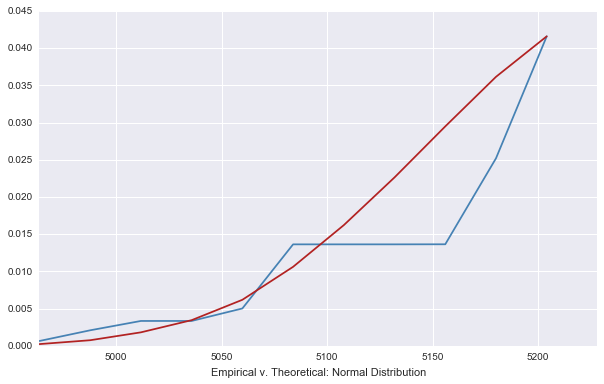

In [86]:
numeric_colms = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for key in numeric_colms:    
    graph_boxplot(df[key], key)
    graph_normal_ref(df[key])

From the above, it looks like 'cons.price.idx' and 'cons.con.idx' are normally distributed.

Finally, let's look at the trend, if any, each attribute has on the whether the client subscribes to a term deposit, starting with the numeric attributes:

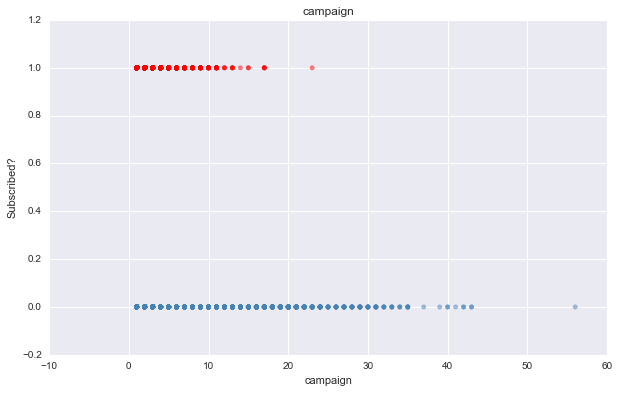

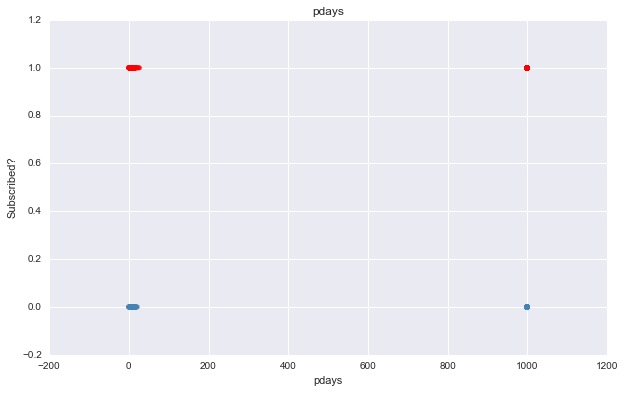

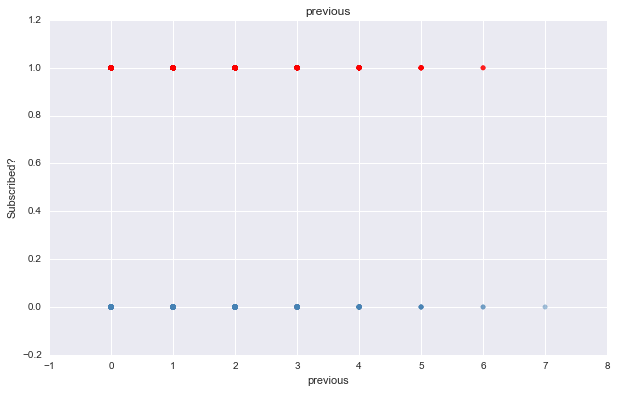

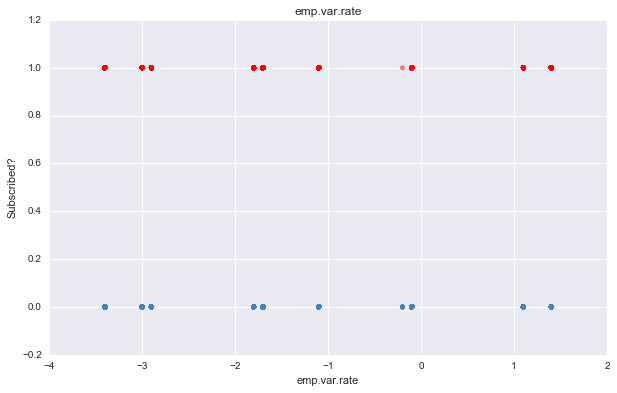

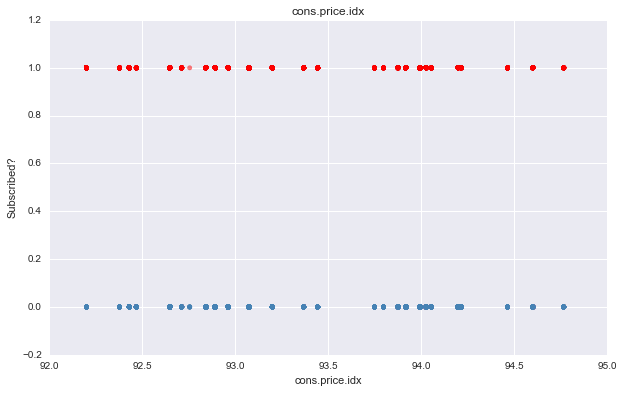

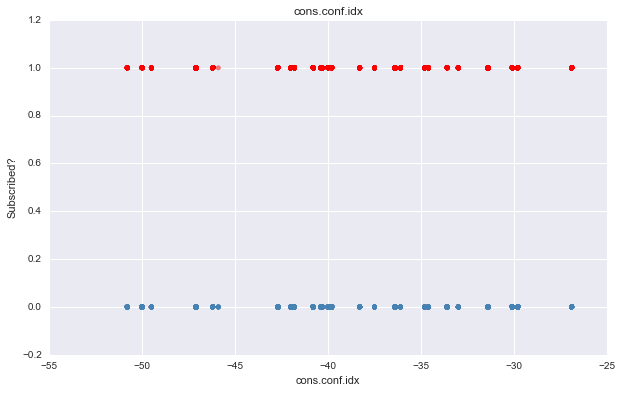

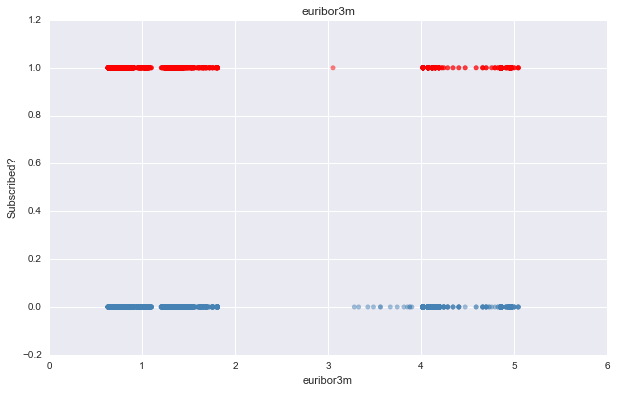

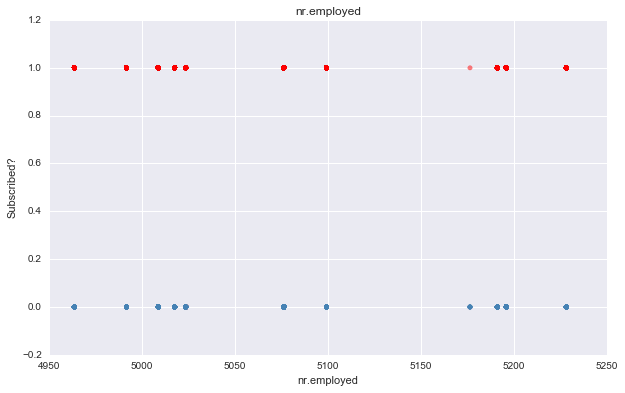

In [87]:
modified_y = list()
colors = list()
for y in df['y'].values:
    if y == 'yes':
        modified_y.append(1)
        colors.append('red')
    else:
        modified_y.append(0)
        colors.append('steelblue')
numeric_colms = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
for key in numeric_colms:
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1, 1, 1)
    axes.scatter(df[key], modified_y, alpha=0.5, color=colors)
    axes.set_xlabel(key)
    axes.set_ylabel("Subscribed?")
    axes.set_title(key)

The only obvious relationship is it appears that of the people who subscribed, none of them were contacted during this campaign more than ~22 times.

Next, let's look at the categorical values and their relationship to whether a person subscribed or not.

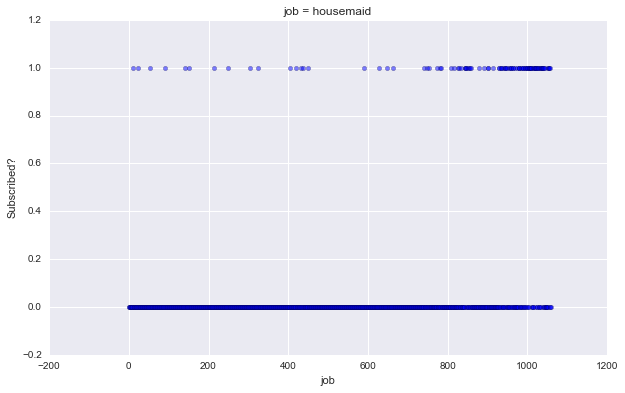

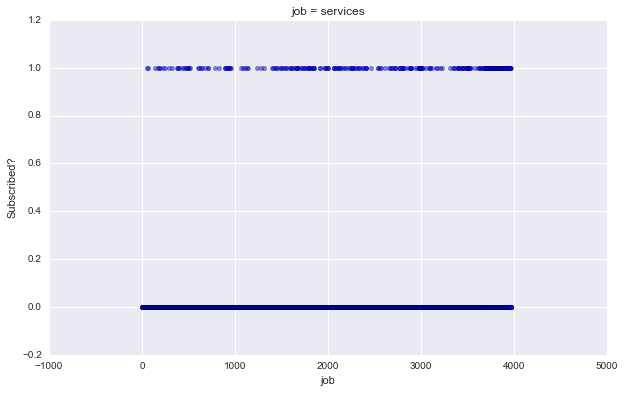

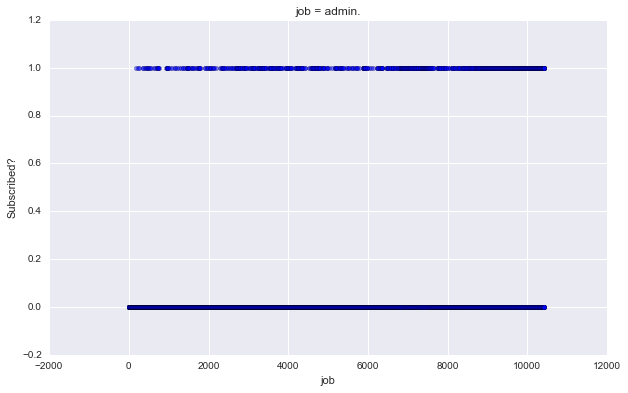

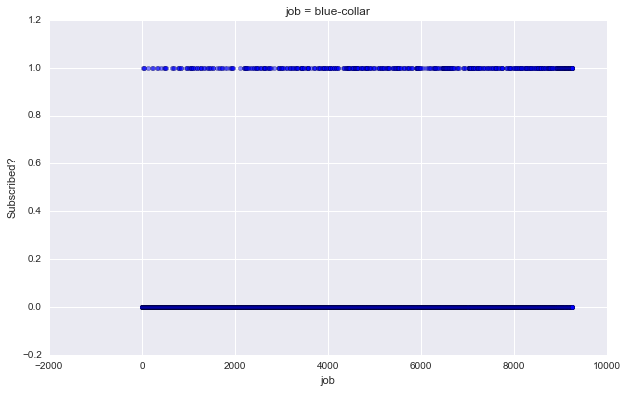

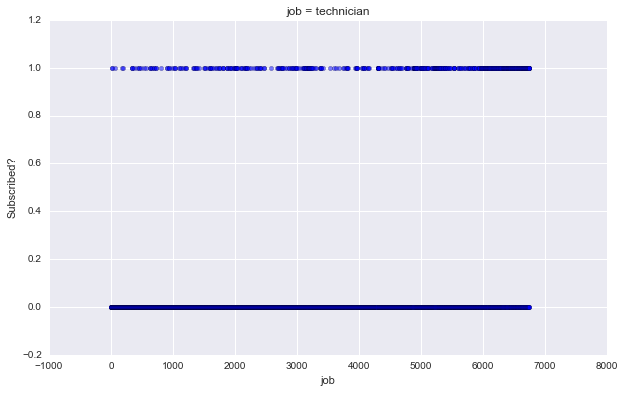

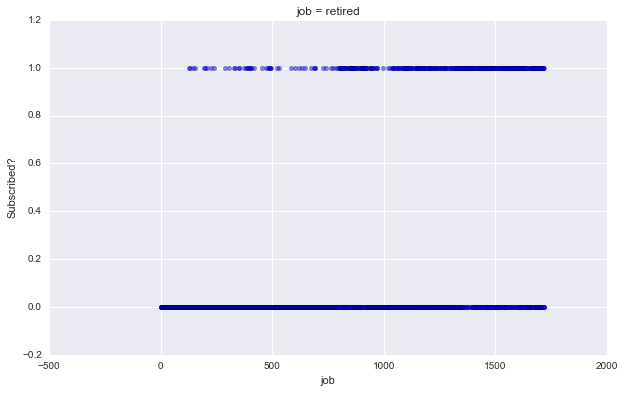

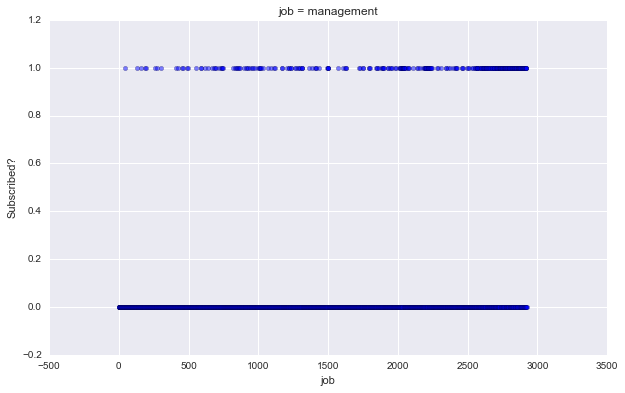

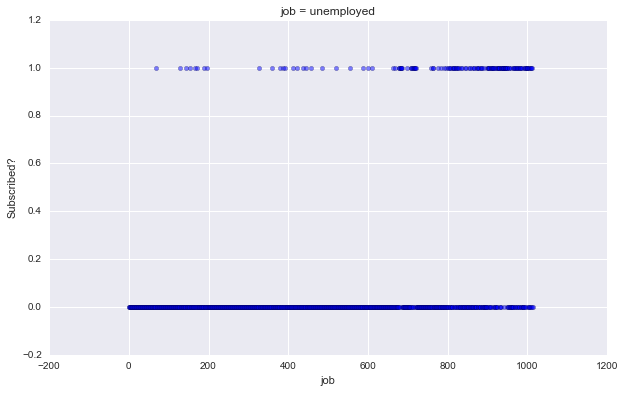

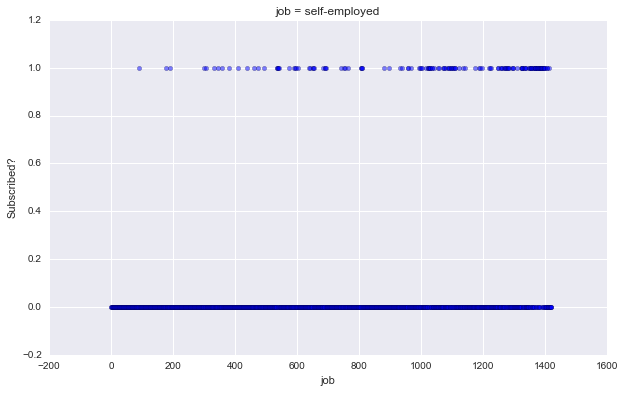

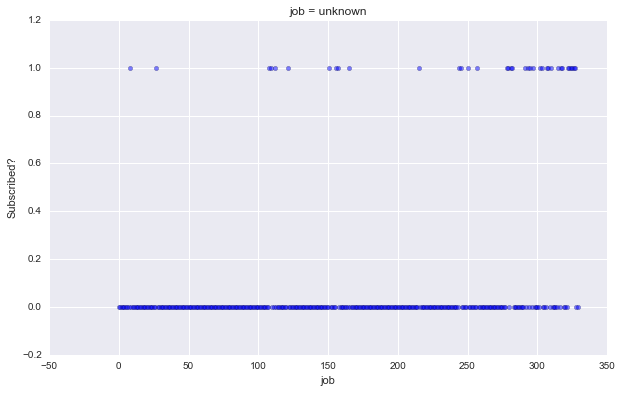

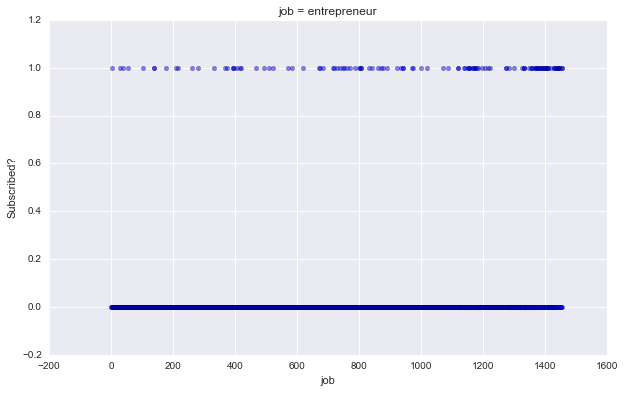

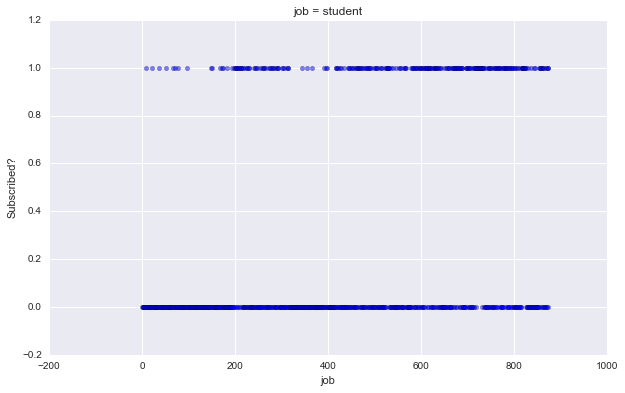

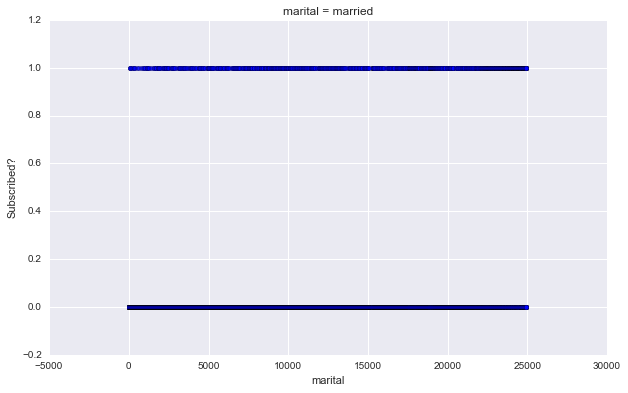

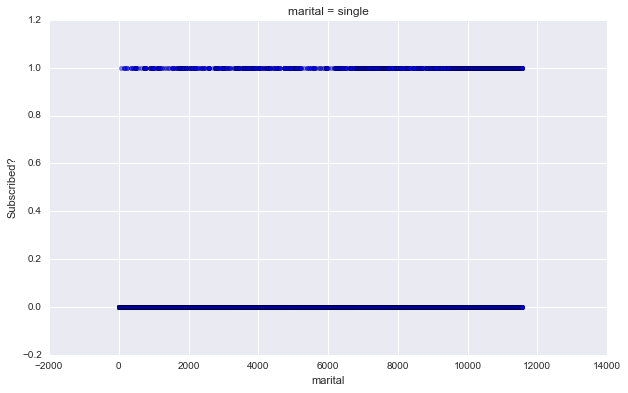

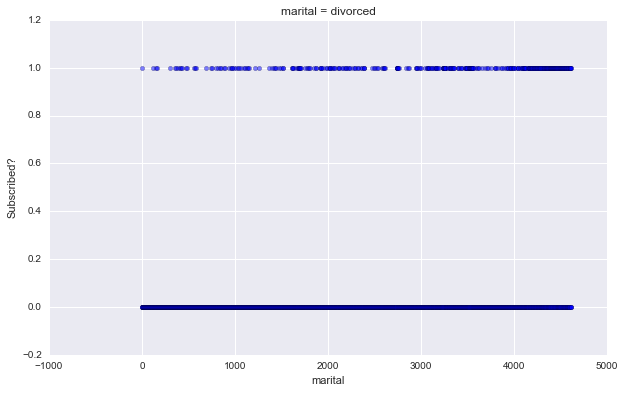

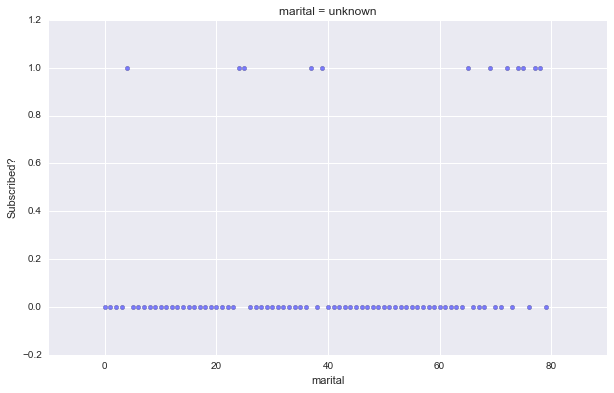

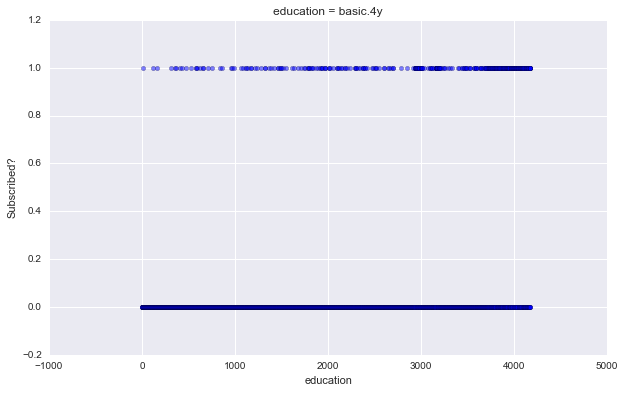

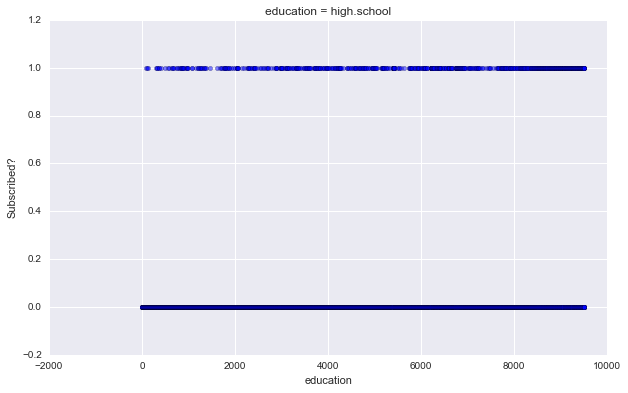

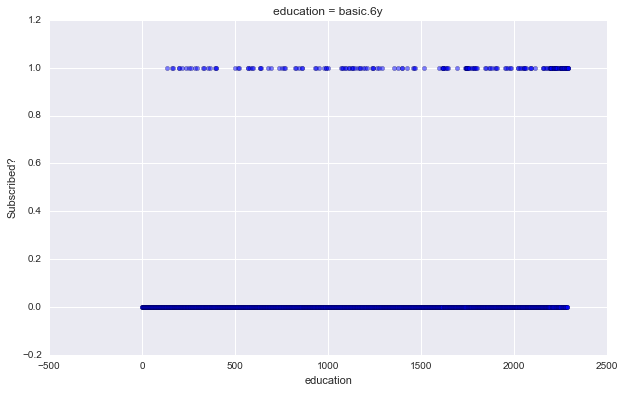

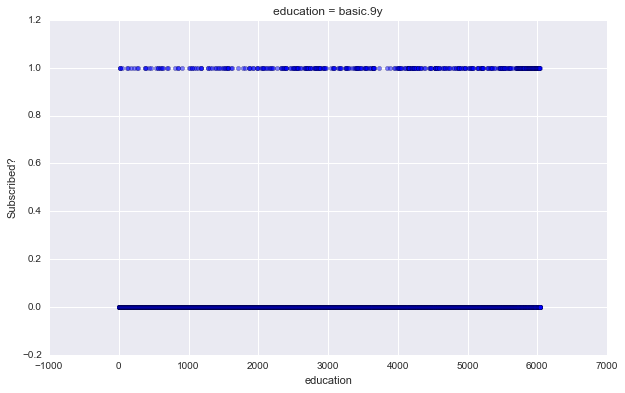

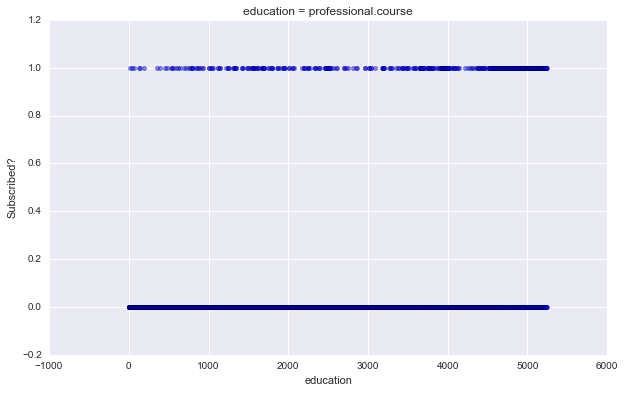

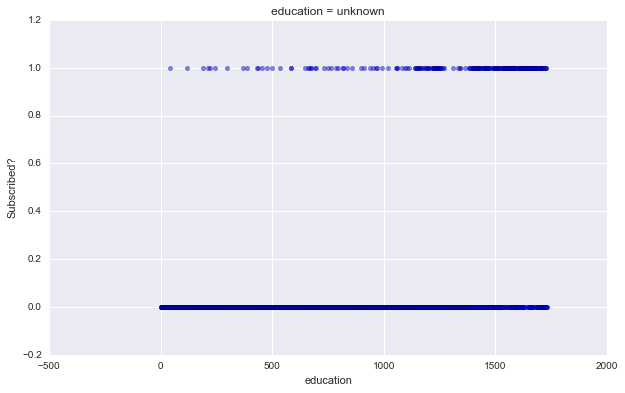

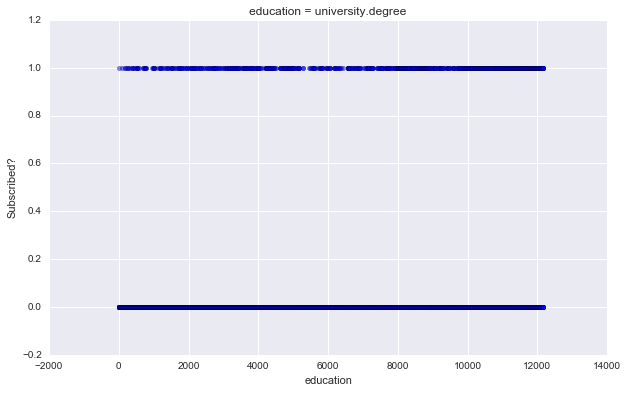

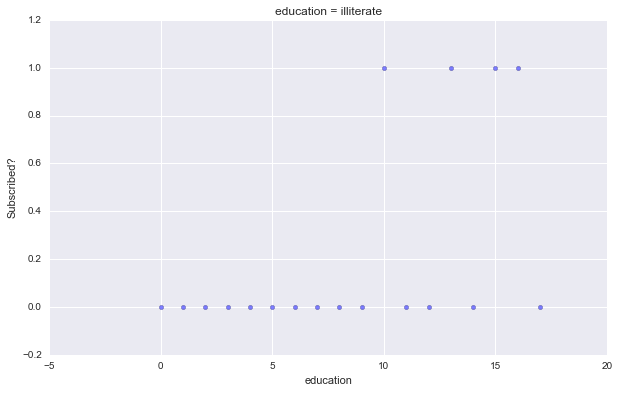

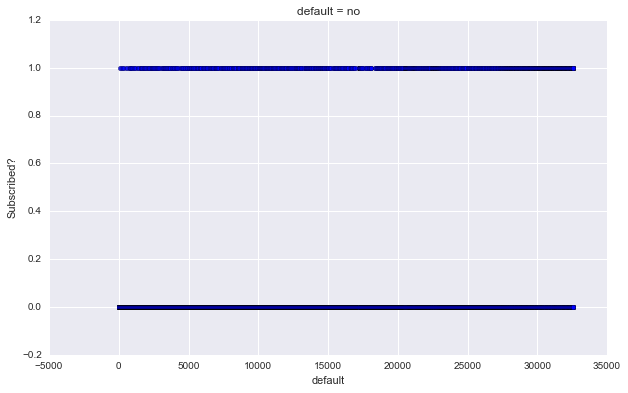

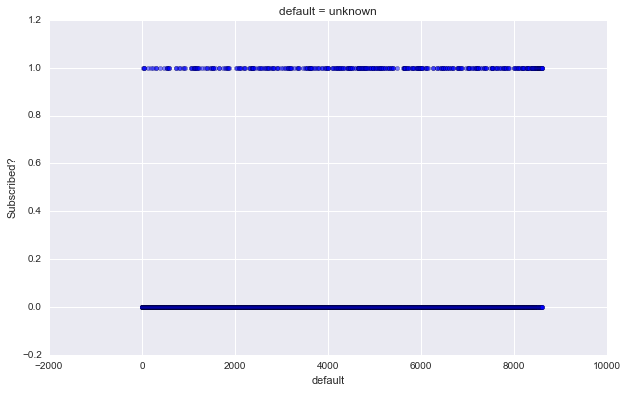

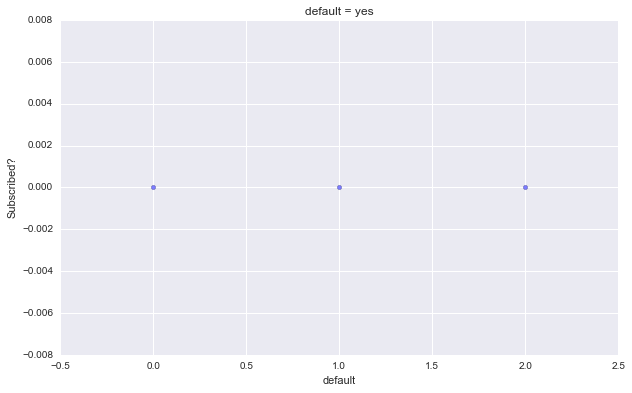

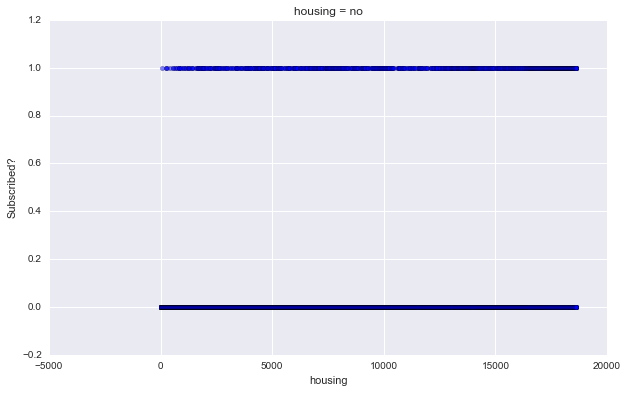

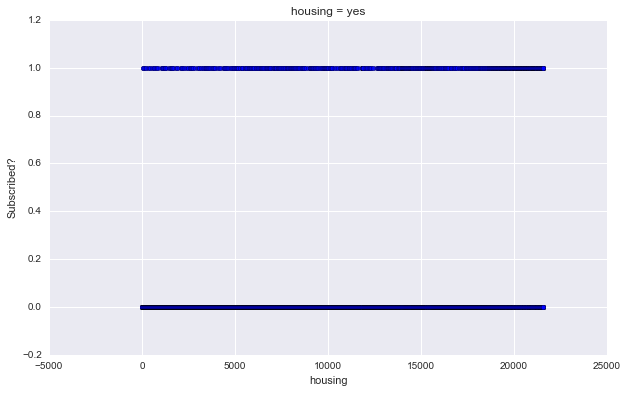

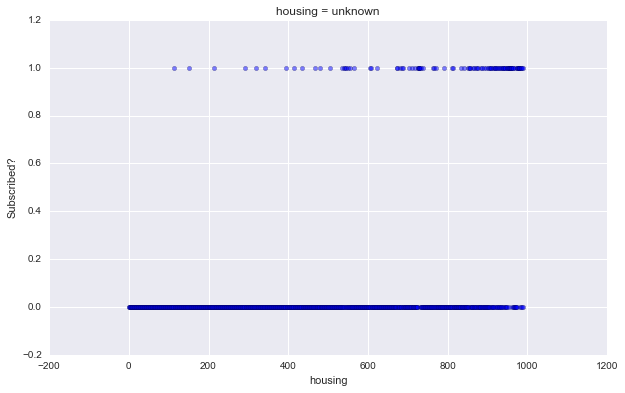

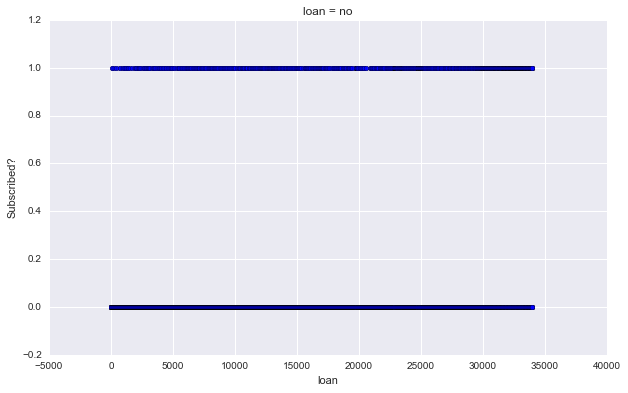

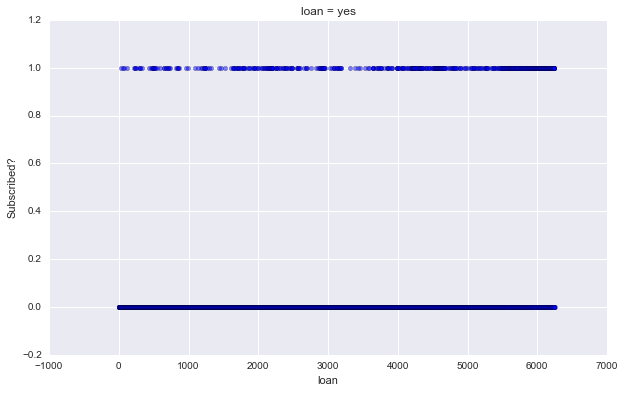

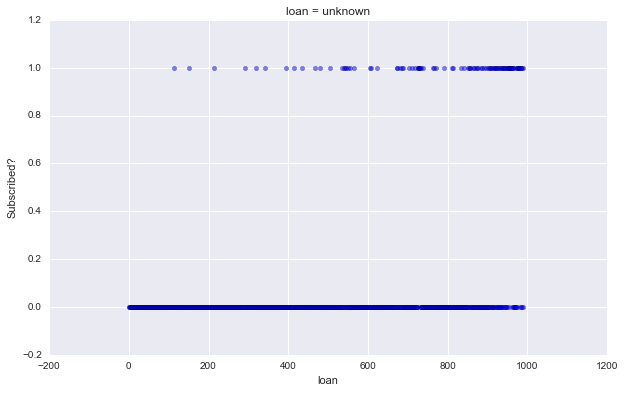

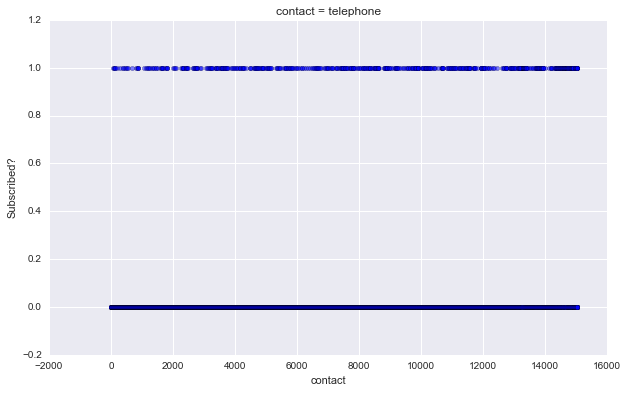

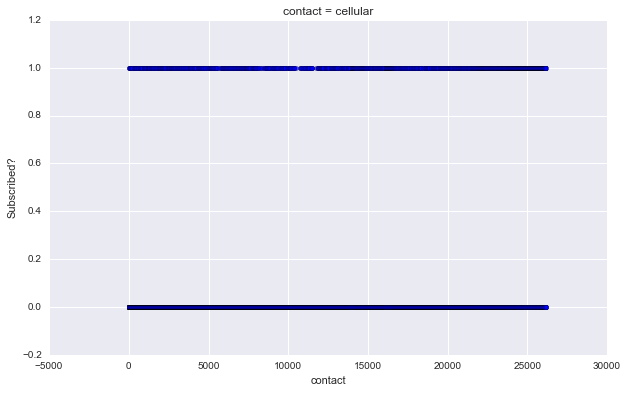

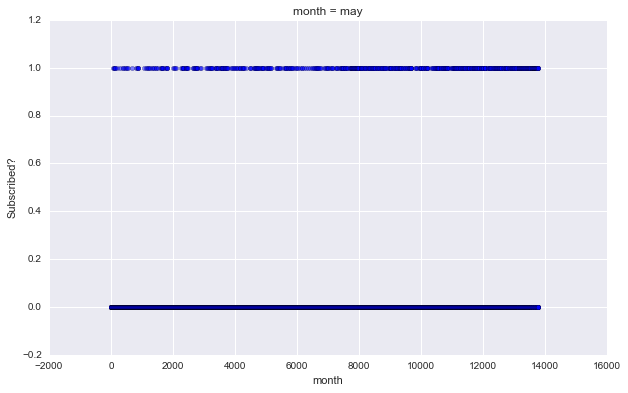

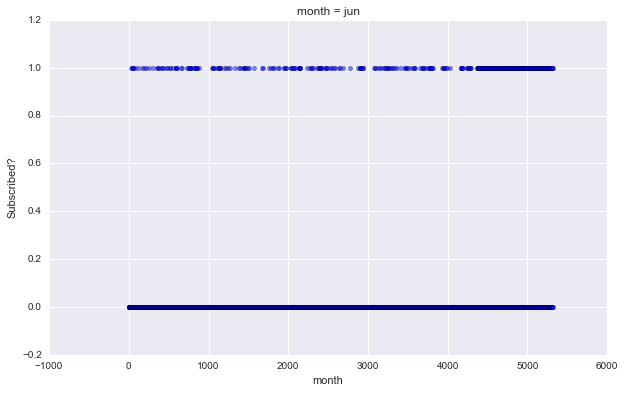

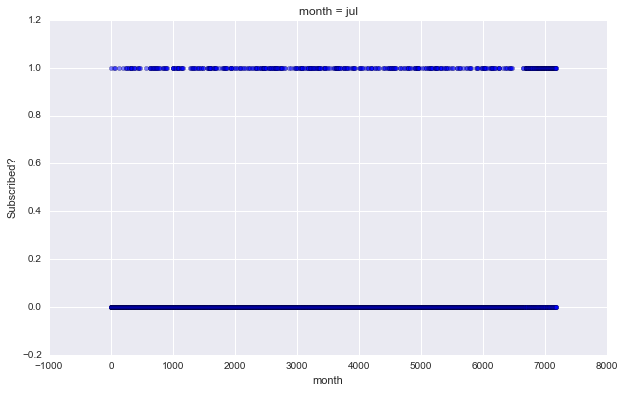

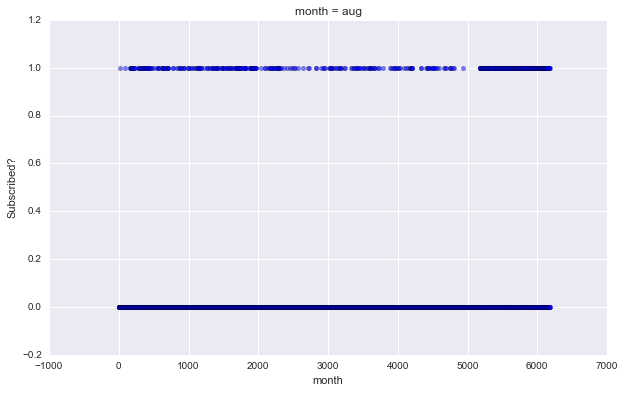

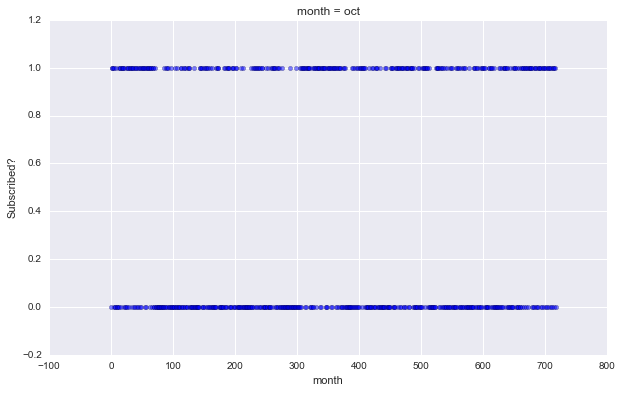

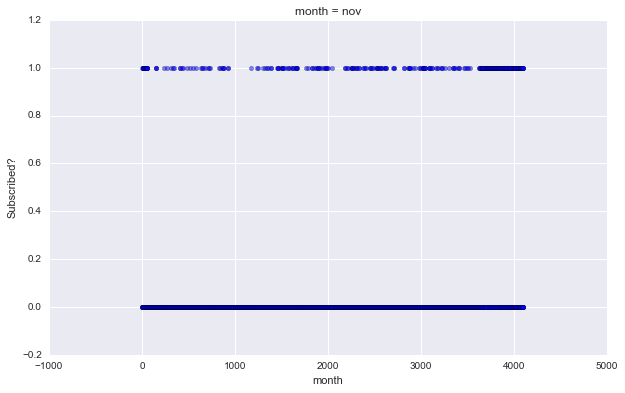

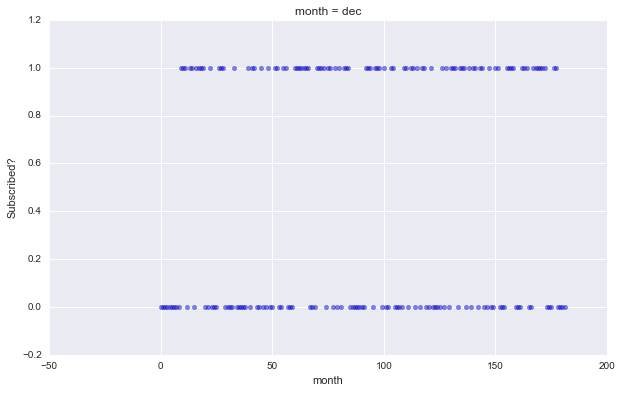

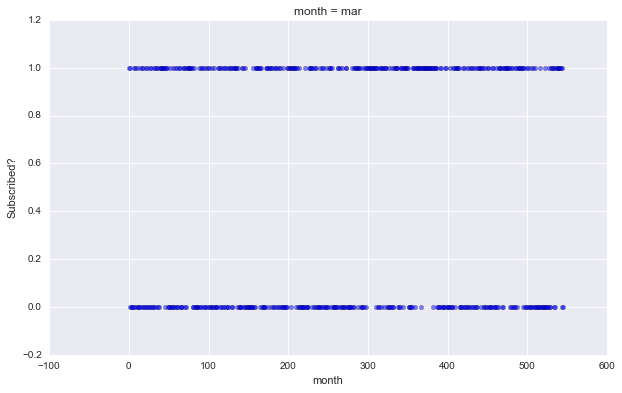

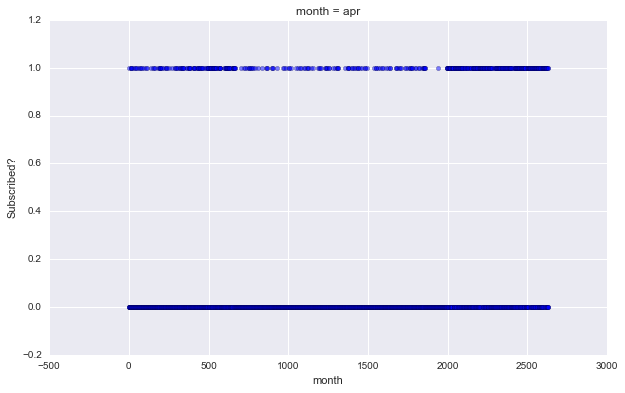

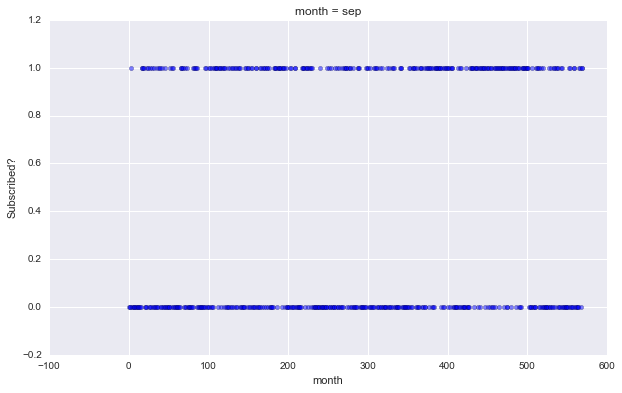

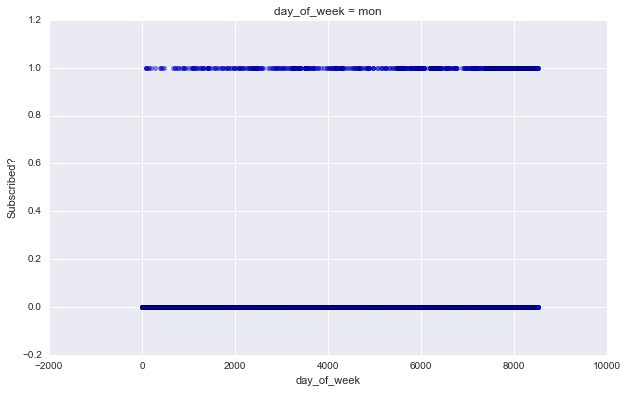

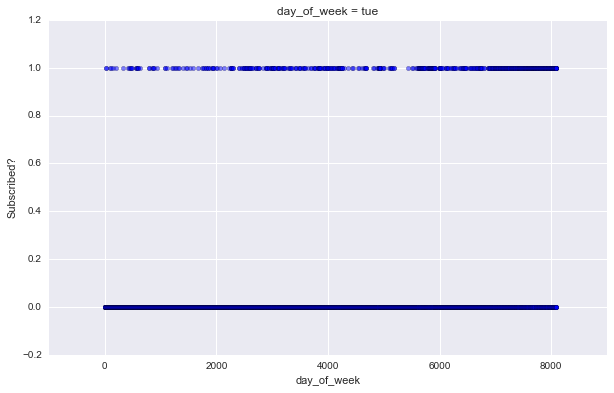

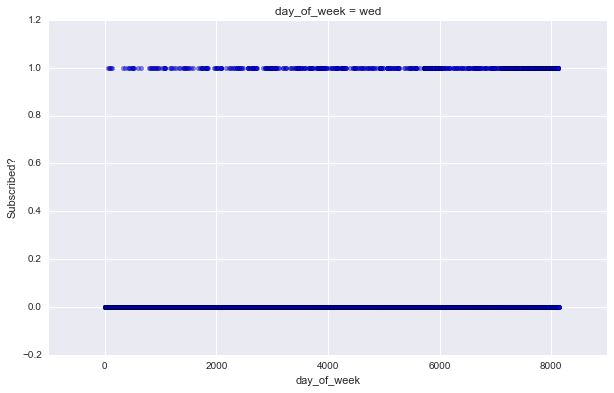

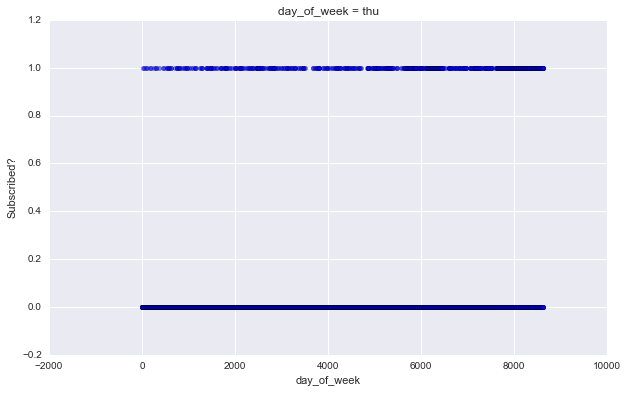

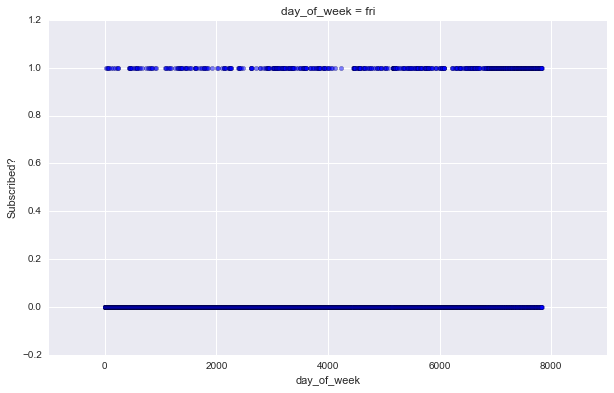

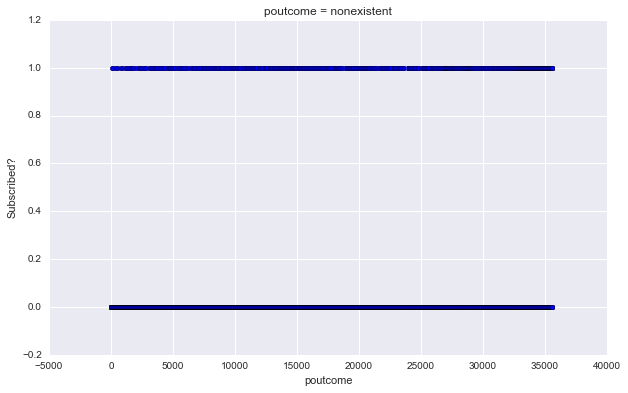

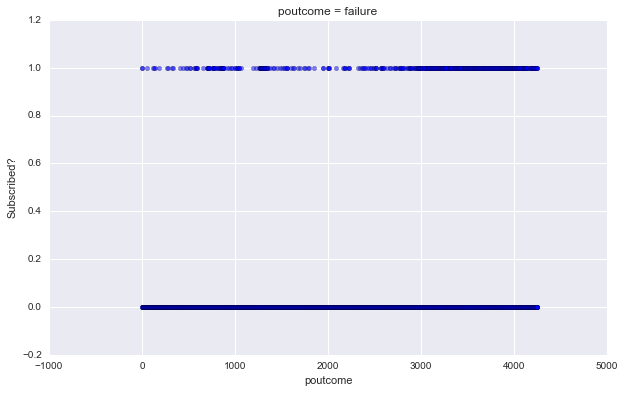

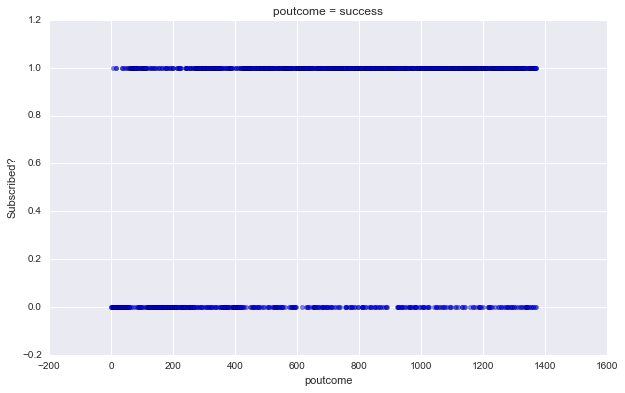

In [88]:
for key in df.keys()[:-1]:
    if df[key].dtype == 'object':
        for val in df[key].unique():
            temp = df.loc[df[key] == val]
            modified_y = list()
            for y in temp['y'].values:
                if y == 'yes':
                    modified_y.append(1)
                else:
                    modified_y.append(0)
            figure = plt.figure(figsize=(10,6))
            axes = figure.add_subplot(1, 1, 1)
            axes.scatter(xrange(len(temp)), modified_y, alpha=0.5)
            axes.set_xlabel(key)
            axes.set_ylabel("Subscribed?")
            axes.set_title("%s = %s" % (key, val))
            plt.show()

'Eye balling' these charts can give a sense of if any categorical values are more or less likely to subscribe. These high-level analysis isn't perfect since it doesn't account for the number of data points per graph but it can give at least an estimate of trends. Some interesting ones:<br>

*People who worked as housemaids, were unemployed, were self-employed, or whose job was ‘unknown’ look less likely than the other occupations to subscribe for a loan.<br>

*Divorcees look the least likely of the martial statuses to subscribe.<br>

*It looks like people who already had an outstanding loan were slightly less likely to subscribe than people without loans.<br>

This concludes my EDA. Turning my attention to learning a decision tree, I have to start by picking a performance metric with which to grade any potential trees. For this, I like the standard accuracy metric because it is simple to interpret and compute. Also, in the absence of domain knowledge it is a safe pick because correct guesses and incorrect guesses are weighted the same (instead of the disease case, which might not apply to this data).

Now, let's start by tuning some decision tree hyperparameters, first starting with the max depth of the tree.

Before we start tuning, we have to vectorize some of multi-category attributes:

In [89]:
X_dict = df.T.to_dict().values()

In [90]:
X_dict[0]

{'age': 56,
 'campaign': 1,
 'cons.conf.idx': -36.4,
 'cons.price.idx': 93.994,
 'contact': 'telephone',
 'day_of_week': 'mon',
 'default': 'no',
 'education': 'basic.4y',
 'emp.var.rate': 1.1,
 'euribor3m': 4.857,
 'housing': 'no',
 'job': 'housemaid',
 'loan': 'no',
 'marital': 'married',
 'month': 'may',
 'nr.employed': 5191.0,
 'pdays': 999,
 'poutcome': 'nonexistent',
 'previous': 0,
 'y': 'no'}

In [91]:
vect = DictVectorizer(sparse=False)
instances = vect.fit_transform(X_dict)

Let's first calculate the generalization error with all the defaults of sklearn:

In [118]:
# Cross-validation with the defaults
accuracies = []
for rd in xrange(3):
    generalization_error = []
    np.random.shuffle(instances)
    kf = KFold(instances.shape[0], n_folds=10)
    for train, test in kf:
        # Learn a decision tree
        model = tree.DecisionTreeClassifier()
        model.fit(instances[train, :-2], instances[train, -1])
        predictions = model.predict(instances[test, :-2])
        # Calculate number of correct predictions
        accuracy = (sum(predictions == instances[test, -1]) / float(len(predictions))) * 100
        generalization_error.append(accuracy)
    accuracies.append(np.mean(generalization_error))
    
print "Decision tree accuracy = %f%%" % np.mean(accuracies)

Decision tree accuracy = 84.069805%


Let's try to improve on this by tuning the max depth of the tree and the minimum number of samples at a leaf:

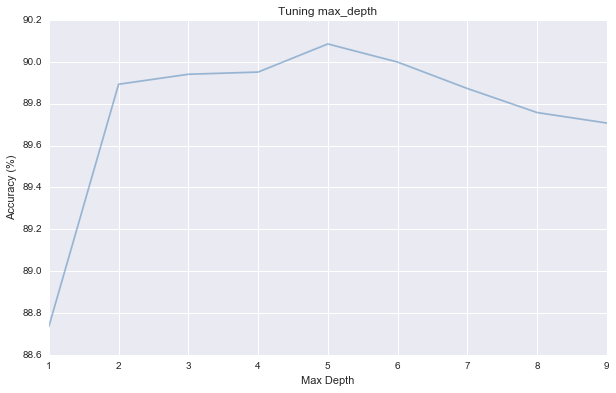

In [121]:
np.random.seed(2034)
ys = []
for max_depth in xrange(1, 10):
    accuracies = []
    for rd in xrange(3):
        generalization_error = []
        np.random.shuffle(instances)
        kf = KFold(instances.shape[0], n_folds=10)
        for train, test in kf:
            # Learn a decision tree
            model = tree.DecisionTreeClassifier(max_depth=max_depth)
            model.fit(instances[train, :-2], instances[train, -1])
            predictions = model.predict(instances[test, :-2])
            # Calculate number of correct predictions
            accuracy = (sum(predictions == instances[test, -1]) / float(len(predictions))) * 100
            generalization_error.append(accuracy)
        accuracies.append(np.mean(generalization_error))
    ys.append(np.mean(accuracies))

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.set_xticks([i for i in xrange(1, 10)])
axes.plot(xrange(1, 10), ys, alpha=0.5, color='steelblue')
axes.set_xlabel("Max Depth")
axes.set_ylabel("Accuracy (%)")
axes.set_title("Tuning max_depth")

Now let's tune the minimum number of samples per leaf node:

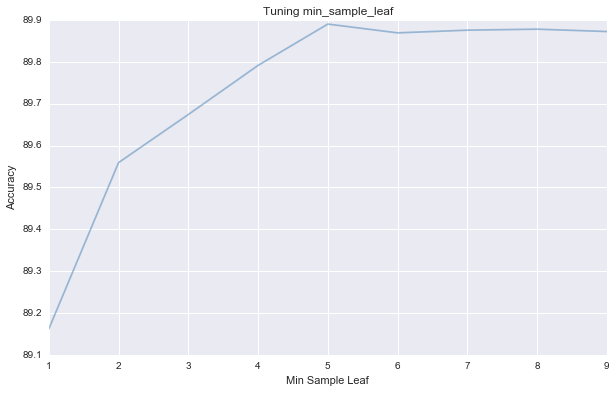

In [124]:
np.random.seed(2034)
ys = []
for min_sample in xrange(10, 100, 10):
    accuracies = []
    for rd in xrange(3):
        generalization_error = []
        np.random.shuffle(instances)
        kf = KFold(instances.shape[0], n_folds=10)
        for train, test in kf:
            # Learn a decision tree
            model = tree.DecisionTreeClassifier(min_samples_leaf=min_sample)
            model.fit(instances[train, :-2], instances[train, -1])
            predictions = model.predict(instances[test, :-2])
            # Calculate number of correct predictions
            accuracy = (sum(predictions == instances[test, -1]) / float(len(predictions))) * 100
            generalization_error.append(accuracy)
        accuracies.append(np.mean(generalization_error))
    ys.append(np.mean(accuracies))

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.set_xticks([i for i in xrange(1, 10)])
axes.plot(xrange(1, 10), ys, alpha=0.5, color='steelblue')
axes.set_xlabel("Min Sample Leaf")
axes.set_ylabel("Accuracy")
axes.set_title("Tuning min_sample_leaf")

The updated accuracy with all the tuned parameters is:

In [125]:
# Cross-validation with the defaults
accuracies = []
for rd in xrange(3):
    generalization_error = []
    np.random.shuffle(instances)
    kf = KFold(instances.shape[0], n_folds=10)
    for train, test in kf:
        # Learn a decision tree
        model = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)
        model.fit(instances[train, :-2], instances[train, -1])
        predictions = model.predict(instances[test, :-2])
        # Calculate number of correct predictions
        accuracy = (sum(predictions == instances[test, -1]) / float(len(predictions))) * 100
        generalization_error.append(accuracy)
    accuracies.append(np.mean(generalization_error))
    
print "Decision tree accuracy = %f%%" % np.mean(accuracies)

Decision tree accuracy = 89.970365%


That's an improvement of 5%, which isnt' bad.

Let's see what this tree looks like when we learn from all the data:

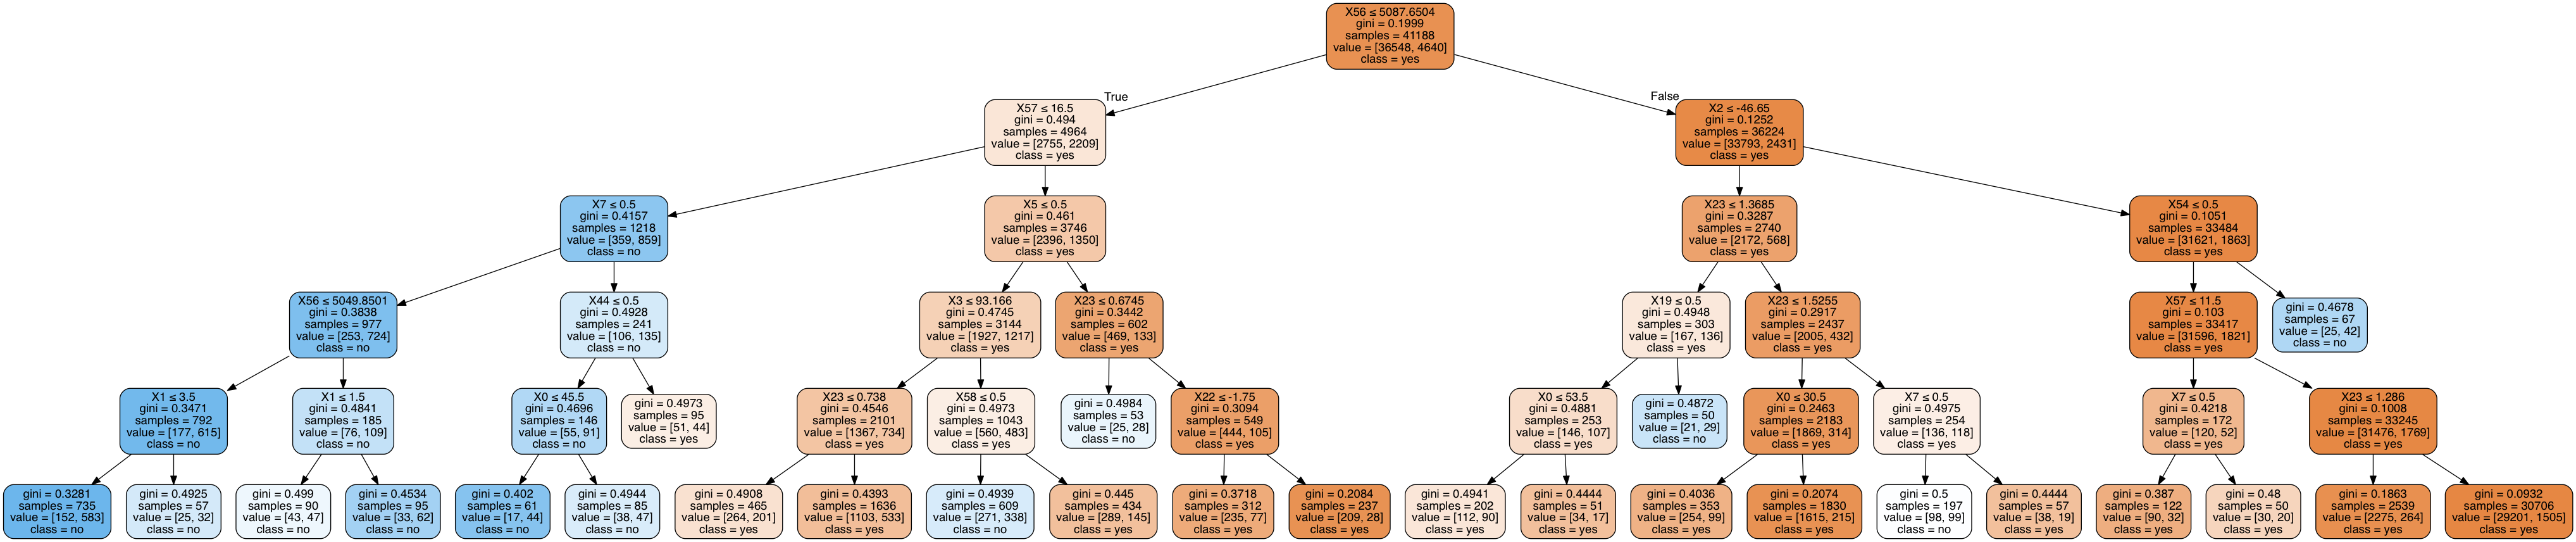

In [127]:
model = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)
model.fit(instances[:, :-2], instances[:, -1])
dot_data = tree.export_graphviz(model, out_file="temp",
                         class_names=['yes', 'no'],  
                         filled=True, rounded=True,  
                         special_characters=True)
with open('temp', 'r') as myfile:
    dot_data=myfile.read().replace('\n', '')
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

Since we vectorized the original columns, it is hard to directly interpret the tree but the top three nodes are split on X56, X2, and X57. According to our dictionary:

In [128]:
vect.vocabulary_

{'age': 0,
 'campaign': 1,
 'cons.conf.idx': 2,
 'cons.price.idx': 3,
 'contact=cellular': 4,
 'contact=telephone': 5,
 'day_of_week=fri': 6,
 'day_of_week=mon': 7,
 'day_of_week=thu': 8,
 'day_of_week=tue': 9,
 'day_of_week=wed': 10,
 'default=no': 11,
 'default=unknown': 12,
 'default=yes': 13,
 'education=basic.4y': 14,
 'education=basic.6y': 15,
 'education=basic.9y': 16,
 'education=high.school': 17,
 'education=illiterate': 18,
 'education=professional.course': 19,
 'education=university.degree': 20,
 'education=unknown': 21,
 'emp.var.rate': 22,
 'euribor3m': 23,
 'housing=no': 24,
 'housing=unknown': 25,
 'housing=yes': 26,
 'job=admin.': 27,
 'job=blue-collar': 28,
 'job=entrepreneur': 29,
 'job=housemaid': 30,
 'job=management': 31,
 'job=retired': 32,
 'job=self-employed': 33,
 'job=services': 34,
 'job=student': 35,
 'job=technician': 36,
 'job=unemployed': 37,
 'job=unknown': 38,
 'loan=no': 39,
 'loan=unknown': 40,
 'loan=yes': 41,
 'marital=divorced': 42,
 'marital=marri

to 'nr.employed', 'cons.conf.idx', and 'pdays'. This isn't what I expected because, from EDA, it didn't look like these attributes produced meaningful splits of the data.

Let's now learn a logistic regression model:

In [178]:
# Cross-validation with the defaults
accuracies = []
for rd in xrange(3):
    generalization_error = []
    np.random.shuffle(instances)
    kf = KFold(instances.shape[0], n_folds=10)
    for train, test in kf:
        # Learn a decision tree
        model = linear.LogisticRegression()
        model.fit(instances[train, :-2], instances[train, -1])
        predictions = model.predict(instances[test, :-2])
        # Calculate number of correct predictions
        accuracy = (sum(predictions == instances[test, -1]) / float(len(predictions))) * 100
        generalization_error.append(accuracy)
    accuracies.append(np.mean(generalization_error))
    
print "Logistic regression model accuracy = %f%%" % np.mean(accuracies)

Logistic regression model accuracy = 90.003561%


The logistic regression model 'outperformed' the decision tree by 0.01%. For all intents and purposes, they performed the exact same, although the logistic model didn't have any hyperparameters to tune and so worked better 'out-of-the-box'.

To interpret the coefficients of the model, let's build a logistic model with all the data:

In [175]:
formula = "attr_63 ~ " + "+".join(["attr_" + str(i) for i in xrange(len(vect.feature_names_[:-2]))])
new_df = pd.DataFrame(instances, columns=["attr_" + str(i) for i in xrange(len(vect.feature_names_))])
result = bootstrap_logm(formula, data=new_df)
#describe_bootstrap_fit(result)

In [177]:
print "regression: ", result[ "formula"]
print "n: ", result[ "n"]
print "----------"

bounds = result[ "resampled_coefficients"].quantile([0.025, 0.975])
bounds = bounds.transpose()
bounds = bounds.values.tolist()

for variable, coefficient, bound in zip( result[ "variables"], result["coefficients"], bounds):
    print variable + ": ", coefficient, bound 
 
print "Accuracy: %f%%" % (sum(abs(result['residuals'])) / len(result['residuals']) * 100)

regression:  attr_63 ~ attr_0+attr_1+attr_2+attr_3+attr_4+attr_5+attr_6+attr_7+attr_8+attr_9+attr_10+attr_11+attr_12+attr_13+attr_14+attr_15+attr_16+attr_17+attr_18+attr_19+attr_20+attr_21+attr_22+attr_23+attr_24+attr_25+attr_26+attr_27+attr_28+attr_29+attr_30+attr_31+attr_32+attr_33+attr_34+attr_35+attr_36+attr_37+attr_38+attr_39+attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_46+attr_47+attr_48+attr_49+attr_50+attr_51+attr_52+attr_53+attr_54+attr_55+attr_56+attr_57+attr_58+attr_59+attr_60+attr_61
n:  41188
----------
intercept:  0.00258281846219 [0.0016662729438500022, 0.0028751925392570825]
attr_0:  0.00366517070977 [0.00021781692348387963, 0.006385265617925661]
attr_1:  -0.0155537341149 [-0.07599804286535523, -0.004828537958396328]
attr_2:  0.0239427395734 [0.013298019898208483, 0.032112637830265515]
attr_3:  0.336286906448 [0.22800871714301255, 0.40174961092131994]
attr_4:  0.227077126792 [0.06044759012511628, 0.2839603605903809]
attr_5:  -0.22449430833 [-0.2814923130437852, 

In [188]:
means = new_df.mean()[:-2]
for idx in xrange(len(new_df.columns[:-2])):
    attr = "attr_" + str(idx)
    print "Testing a unit increase of %s" % attr
    around_mean = logistic(result["coefficients"][0] + np.dot(result["coefficients"][1:], means))
    means[attr] += 1
    moved_one_unit = logistic(result["coefficients"][0] + np.dot(result["coefficients"][1:], means))
    print "P(y = 1) = ", around_mean
    print "P(y = 1) = after 1 unit increase to %s = %f" % (attr, moved_one_unit)
    print "Difference of ", moved_one_unit - around_mean
    print "\n"
    means[attr] -= 1

Testing a unit increase of attr_0
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to attr_0 = 0.077411
Difference of  0.000261355409906


Testing a unit increase of attr_1
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to attr_1 = 0.076049
Difference of  -0.00110012791449


Testing a unit increase of attr_2
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to attr_2 = 0.078871
Difference of  0.00172201270165


Testing a unit increase of attr_3
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to attr_3 = 0.104758
Difference of  0.0276090351919


Testing a unit increase of attr_4
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to attr_4 = 0.094949
Difference of  0.017800035219


Testing a unit increase of attr_5
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to attr_5 = 0.062607
Difference of  -0.0145419579808


Testing a unit increase of attr_6
P(y = 1) =  0.0771494430207
P(y = 1) = after 1 unit increase to att

As far as interpretability goes, I think the decision tree model is easier to interpret. For one, determining a classification for an unseen example is easy to figure out even manually with a decision tree. In addition, being able to picture the model gives the human operators the chance to interact, overrule, and inject domain knowledge into the model. Decision trees also have the benefit that they can easily produce knowledge rules. The overall visibility of decision tree is a benefit when interacting with non-data types. This comes in especially handy when we want to drum up support for our model within an organization.

Given the choice between a logistic regression model and a decision tree model, I'd choose the decision tree model each time (assuming performance was similar). Its visibility easily allows non-data types to interact with it, it gives engineers a window into what the model is thinking and provides a way to for the model to 'explain' its decisions. In addition, when the model is blantedly wrong, maintainers can easily see the internals of the model to fix it. Lastly, decision trees are easy to implement from nothing, which is useful even if your team doesn't plan on implementing themselves.